
## Matches DESI observations to DECam to get a redshift

This code predominately takes in data from the ALERCE and DECAM ledger brokers and identifies the closest DESI galaxy within 4 arcseconds of those objects, suspected to be transients. 

The main matching algorithm uses astropy's **match_coordinate_sky** to match 1-to-1 targets with the objects from the two ledgers. Wrapping functions handle data retrieval from both the ledgers as well as from DESI and prepare this data to be fed into **match_coordinate_sky**. Since ALERCE returns a small enough (pandas) dataframe, we do not need to precondition the input much. However, DECAM has many more objects to match so we use a two-stage process: an initial 2 degree match to tile RA's/DEC's and a second closer 1 arcsecond match to individual targets. 


In [4]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.time import Timefrom astropy.coordinates import SkyCoord, match_coordinates_sky, Angle


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import sys

import sqlite3
import os

from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra

# Some handy global variables
global db_filename
db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
global exposure_path
exposure_path = os.environ["DESI_SPECTRO_REDUX"]
global color_band
color_band = "r"

global today
today = Time.now()

In [18]:

def plt_style():
    plt.rcParams.update({
                        'lines.linewidth':1.0,
                        'lines.linestyle':'-',
                        'lines.color':'black',
                        'font.family':'serif',
                        'font.weight':'normal',
                        'font.size':13.0,
                        'text.color':'black',
                        'text.usetex':True,
                        'axes.edgecolor':'black',
                        'axes.linewidth':1.0,
                        'axes.grid':False,
                        'axes.titlesize':'x-large',
                        'axes.labelsize':'x-large',
                        'axes.labelweight':'normal',
                        'axes.labelcolor':'black',
                        'axes.formatter.limits':[-4,4],
                        'xtick.major.size':7,
                        'xtick.minor.size':4,
                        'xtick.major.pad':8,
                        'xtick.minor.pad':8,
                        'xtick.labelsize':'medium',
                        'xtick.minor.width':1.0,
                        'xtick.major.width':1.0,
                        'ytick.major.size':7,
                        'ytick.minor.size':4,
                        'ytick.major.pad':8,
                        'ytick.minor.pad':8,
                        'ytick.labelsize':'medium',
                        'ytick.minor.width':1.0,
                        'ytick.major.width':1.0,
                        'legend.numpoints':1,
                        #'legend.fontsize':'x-large',
                        'legend.shadow':False,
                        'legend.frameon':False})


# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)





## Necessary functions

In [5]:
# From https://github.com/desihub/timedomain/blob/master/too_ledgers/decam_TAMU_ledgermaker.ipynb
# Function to grab decam data
from bs4 import BeautifulSoup
import json
import requests
def access_decam_data(url, overwrite=False):
    """Download reduced DECam transient data from Texas A&M.
    Cache the data to avoid lengthy and expensive downloads.
    
    Parameters
    ----------
    url : str
        URL for accessing the data.
    overwrite : bool
        Download new data and overwrite the cached data.
        
    Returns
    -------
    decam_transients : pandas.DataFrame
        Table of transient data.
    """
    folders = url.split('/')
    thedate = folders[-1] if len(folders[-1]) > 0 else folders[-2]
    outfile = '{}.csv'.format(thedate)
    
    if os.path.exists(outfile) and not overwrite:
        # Access cached data.
        decam_transients = pd.read_csv(outfile)
    else:
        # Download the DECam data index.
        # A try/except is needed because the datahub SSL certificate isn't playing well with URL requests.
        try:
            decam_dets = requests.get(url, auth=('decam','tamudecam')).text
        except:
            requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)
            decam_dets = requests.get(url, verify=False, auth=('decam','tamudecam')).text
            
        # Convert transient index page into scrapable data using BeautifulSoup.
        soup = BeautifulSoup(decam_dets)
        
        # Loop through transient object summary JSON files indexed in the main transient page.
        # Download the JSONs and dump the info into a Pandas table.
        decam_transients = None
        j = 0

        for a in soup.find_all('a', href=True):
            if 'object-summary.json' in a:
                link = a['href'].replace('./', '')
                summary_url  = url + link        
                summary_text = requests.get(summary_url, verify=False, auth=('decam','tamudecam')).text
                summary_data = json.loads(summary_text)

                j += 1
                #print('Accessing {:3d}  {}'.format(j, summary_url)) # Modified by Matt

                if decam_transients is None:
                    decam_transients = pd.DataFrame(summary_data, index=[0])
                else:
                    decam_transients = pd.concat([decam_transients, pd.DataFrame(summary_data, index=[0])])
                    
        # Cache the data for future access.
        print('Saving output to {}'.format(outfile))
        decam_transients.to_csv(outfile, index=False)
        
    return decam_transients

In [6]:
# Function to read in fits table info, RA, DEC, MJD and targetid if so desired
# Uses control parameter tile to determine if opening tile exposure file or not since headers are different

def read_fits_info(filepath: str, tile = True):
    
    if tile:
        hdu_num = 5
    else:
        hdu_num = 1
    
    try:
        with fits.open(filepath) as hdu1:
    
            data_table = Table(hdu1[hdu_num].data) #columns
        
            targ_id = data_table['TARGETID'].astype(int)
            targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            targ_dec = data_table['TARGET_DEC'].data
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
            if tile:
                targ_mjd = hdu1[hdu_num].header['MJD-OBS']
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        print("In path:", filepath)
        print("Trying the next file...")
        return np.array([]), np.array([]), np.array([])
    
    if not tile:
        targ_mjd = filepath.split("/")[-1].split("_")[-2] #to grab the date
        targ_mjd = targ_mjd[:4]+"-"+targ_mjd[4:6]+"-"+targ_mjd[6:] # Adding dashes for Time
        targ_mjd = Time(targ_mjd).mjd
    
    return targ_ra, targ_dec, targ_mjd, targ_id

## Matching to DECAM functions

In [7]:
# Grabbing the frame fits files
def glob_frames(exp_d: str):    
    # This function grabs the names of all input files in the transient directory and does some python string manipulation
    # to grab the names of the input files with full path and the filenames themselves.

    try:
        filenames_read = glob.glob(exp_d + "/cframe-" + color_band + "*.fits") # Only need one of b, r, z
        # sframes not flux calibrated
        # May want to use tiles... coadd (will need later, but not now)
    
    except:
        print("Could not grab/find any fits in the exposure directory:")
        print(exp_d)
        filenames_read = [] # Just in case
        #filenames_out = [] # Just in case
        raise SystemExit("Exiting.")
        
    #else:
        #filenames_out = [s.split(".")[0] for s in filenames_read]
        #filenames_out = [s.split("/")[-1] for s in filenames_read]
        #filenames_out = [s.replace("in", "out") for s in filenames_out]
        
    return filenames_read #, filenames_out

#path_to_transient = "/global/cfs/cdirs/desi/science/td/daily-search/desitrip/out"
#print(all_candidate_filenames(path_to_transient)[1])

## Grab DECAM ledger as pandas dataframe

In [12]:
decam_transients = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/', overwrite = False) # If True, grabs a fresh batch

In [9]:
decam_transients_agn = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy_AGN/', overwrite = False) # If True, grabs a fresh batch

In [10]:
decam_transients

ObjectID   RA-OBJECT  DEC-OBJECT  NumberAlerts  MaxSCORE  \
0    A202103221407558m001825  211.982786   -0.306951          12.0     0.972   
1    A202103221408139m033502  212.057952   -3.583947          28.0     0.954   
2    A202103221408412p002445  212.171737    0.412527          49.0     0.998   
3    A202103221408578m005300  212.241200   -0.883300           2.0     0.855   
4    A202103221409059m023156  212.274757   -2.532478          21.0     0.969   
..                       ...         ...         ...           ...       ...   
553  T202106021440559m025615  220.233290   -2.937658           4.0     0.940   
554  T202106021442286m035936  220.619578   -3.993391           3.0     0.935   
555  T202106021449003p003225  222.251305    0.540528           7.0     0.984   
556  T202106051435333m000534  218.888992   -0.092877           2.0     0.857   
557                      NaN         NaN         NaN           NaN       NaN   

     RA-PSEUDO-HOST  DEC-PSEUDO-HOST  SEP-PSEUDO-HOST  RA-NEIGHBOR-STAR  \
0        211.982614        -0.306946           0.6199        211.983372   
1        212.057864        -3.583960           0.3199        212.058798   
2        212.171673         0.412394           0.5317        212.174697   
3        212.241200        -0.883400           0.3000        212.239800   
4        212.274533        -2.532531           0.8290        212.275356   
..              ...              ...              ...               ...   
553      220.233839        -2.935933           6.5148        220.230799   
554      220.618952        -3.993328           2.2614        220.615993   
555      222.251090         0.540740           1.0845        222.249251   
556      218.889396        -0.095045           7.9375        218.890974   
557             NaN              NaN              NaN               NaN   

     DEC-NEIGHBOR-STAR  ...  Discovery-Round           Discovery-Time  \
0            -0.306315  ...              0.0  2021-03-22T06:40:19.074   
1            -3.586276  ...              0.0  2021-03-22T08:20:58.209   
2             0.411566  ...              0.0  2021-03-22T06:36:50.928   
3            -0.884900  ...              0.0  2021-03-22T08:17:30.880   
4            -2.535003  ...              0.0  2021-03-22T08:14:02.747   
..                 ...  ...              ...                      ...   
553          -2.938535  ...             23.0  2021-06-02T05:33:59.097   
554          -3.991748  ...             23.0  2021-06-02T05:33:59.097   
555           0.544256  ...             23.0  2021-06-02T02:27:20.976   
556          -0.090694  ...             24.0  2021-06-05T02:14:11.170   
557                NaN  ...              NaN                      NaN   

    Discovery-Filter Discovery-Magnitude  Discovery-SNR  Latest-Round  \
0                  N               22.13           19.2           9.0   
1                  N               21.78           25.7          23.0   
2                  S               20.61           36.2          23.0   
3                  S               22.55           15.5           1.0   
4                  N               22.27           10.6          18.0   
..               ...                 ...            ...           ...   
553                S               22.14           13.6          23.0   
554                N               22.15           22.5          23.0   
555                S               21.04           47.1          24.0   
556                N               22.36           21.7          24.0   
557              NaN                 NaN            NaN           NaN   

                 Latest-Time Latest-Filter Latest-Magnitude  Latest-SNR  
0    2021-04-18T05:37:55.763             N            22.86        10.2  
1    2021-06-02T06:00:51.873             N            21.82        18.1  
2    2021-06-02T02:59:21.867             S            21.46        33.9  
3    2021-03-24T07:10:51.368             S            22.33        25.6  
4    2021-05-18T03:17:17.544      

In [13]:
#Match w Everest
import healpy as hp

nside = 64
nest = True

#Define hpixs of transients

hpix_hosts = hp.ang2pix(nside, decam_transients['RA-PSEUDO-HOST'],decam_transients['DEC-PSEUDO-HOST'],
                        lonlat=True, nest = nest )
hpix_hosts_agn = hp.ang2pix(nside, decam_transients_agn['RA-PSEUDO-HOST'],decam_transients_agn['DEC-PSEUDO-HOST'],
                        lonlat=True, nest = nest )

hosts_coords = SkyCoord(decam_transients['RA-PSEUDO-HOST']*u.deg, decam_transients['DEC-PSEUDO-HOST']*u.deg)
hosts_coords_agn = SkyCoord(decam_transients_agn['RA-PSEUDO-HOST']*u.deg, decam_transients_agn['DEC-PSEUDO-HOST']*u.deg)

In [14]:
hpix_hosts_un = np.unique(hpix_hosts)
#Create array to store redshifts. If no redshift available, it will say -9
zhosts = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], -9, dtype=float)
ztype = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], 'NULL', dtype='<U6' )
zwarn = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], -9)
zchi = np.full(decam_transients['RA-PSEUDO-HOST'].shape[0], -9)

hpix_hosts_un_agn = np.unique(hpix_hosts_agn)
#Create array to store redshifts. If no redshift available, it will say -9
zhosts_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], -9, dtype=float)
ztype_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], 'NULL', dtype='<U6' )
zwarn_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], -9)
zchi_agn = np.full(decam_transients_agn['RA-PSEUDO-HOST'].shape[0], -9)

In [15]:
base_dir = '/global/cfs/cdirs/desi/spectro/redux/everest/healpix/'
surveys=['main', 'sv1', 'sv2', 'sv3']
times=['bright','dark']

max_sep = 2 * u.arcsec

for survey in surveys:
    print("Checking survey:", survey)
    for time in times:
        print("Checking ", time, " time")
        for hpix_host in hpix_hosts_un:
            filepath = base_dir+survey+'/'+time+'/'+str(hpix_host)[:-2]+\
            '/'+str(hpix_host)+'/'+'redrock-*fits'
            filename = glob.glob(filepath)
            try:
                h=fits.open(filename[0])
                #print("Opened file", filename)
                desi_ra, desi_dec = h[2].data['target_RA'],h[2].data['target_DEC']
                desi_id = h[2].data['TARGETID']
                desi_id_z = h[1].data['TARGETID']
                desi_z = h[1].data['Z']
                desi_spectype = h[1].data['SPECTYPE']
                desi_zwarn = h[1].data['ZWARN']
                desi_chi2 = h[1].data['DELTACHI2']
                
                # Convert everything to SkyCoord
                desi_coords = SkyCoord(desi_ra*u.deg, desi_dec*u.deg)

                idx_desi, d2d_trans, d3d_trans = match_coordinates_sky(hosts_coords,desi_coords)

                # Filter out the good stuff
                sep_constraint = d2d_trans < max_sep
                
                if idx_desi[sep_constraint].shape[0] >0 : 
                    #print(idx_desi[sep_constraint].shape[0], " matches ")
                    hosts_matches = hosts_coords[sep_constraint]
                    #trans_matches_ids = target_ids_in[sep_constraint]
                    desi_matches = desi_coords[idx_desi[sep_constraint]]
                    #desi_matches_ids = desi_id[idx_alerts[sep_constraint]]

                    zhosts[sep_constraint] = desi_z[idx_desi[sep_constraint]]
                    zchi[sep_constraint] = desi_chi2[idx_desi[sep_constraint]]
                    ztype[sep_constraint] = desi_spectype[idx_desi[sep_constraint]]
                    zwarn[sep_constraint] = desi_zwarn[idx_desi[sep_constraint]]
                
                
                #CHECK TARGETID!!
            except:
                test = 2
                #print("No redrock file found") # for ", filepath)

Checking survey: main
Checking  bright  time
Checking  dark  time
Checking survey: sv1
Checking  bright  time
Checking  dark  time
Checking survey: sv2
Checking  bright  time
Checking  dark  time
Checking survey: sv3
Checking  bright  time
Checking  dark  time


In [ ]:
base_dir = '/global/cfs/cdirs/desi/spectro/redux/everest/healpix/'
surveys=['main', 'sv1', 'sv2', 'sv3']
times=['bright','dark']

max_sep = 2 * u.arcsec

for survey in surveys:
    print("Checking survey:", survey)
    for time in times:
        print("Checking ", time, " time")
        for hpix_host in hpix_hosts_un_agn:
            filepath = base_dir+survey+'/'+time+'/'+str(hpix_host)[:-2]+\
            '/'+str(hpix_host)+'/'+'redrock-*fits'
            filename = glob.glob(filepath)
            try:
                h=fits.open(filename[0])
                #print("Opened file", filename)
                desi_ra, desi_dec = h[2].data['target_RA'],h[2].data['target_DEC']
                desi_id = h[2].data['TARGETID']
                desi_id_z = h[1].data['TARGETID']
                #print(desi_id,desi_id_z)
                desi_z = h[1].data['Z']
                desi_spectype = h[1].data['SPECTYPE']
                desi_zwarn = h[1].data['ZWARN']
                desi_chi2 = h[1].data['DELTACHI2']
                
                # Convert everything to SkyCoord
                desi_coords = SkyCoord(desi_ra*u.deg, desi_dec*u.deg)

                idx_desi, d2d_trans, d3d_trans = match_coordinates_sky(hosts_coords_agn,desi_coords)

                # Filter out the good stuff
                sep_constraint = d2d_trans < max_sep
                
                if idx_desi[sep_constraint].shape[0] >0 : 
                    #print(idx_desi[sep_constraint].shape[0], " matches ")
                    hosts_matches = hosts_coords_agn[sep_constraint]
                    #trans_matches_ids = target_ids_in[sep_constraint]
                    desi_matches = desi_coords[idx_desi[sep_constraint]]
                    #desi_matches_ids = desi_id[idx_alerts[sep_constraint]]

                    zhosts_agn[sep_constraint] = desi_z[idx_desi[sep_constraint]]
                    zchi_agn[sep_constraint] = desi_chi2[idx_desi[sep_constraint]]
                    ztype_agn[sep_constraint] = desi_spectype[idx_desi[sep_constraint]]
                    zwarn_agn[sep_constraint] = desi_zwarn[idx_desi[sep_constraint]]
                
                
                #CHECK TARGETID!!
            except:
                test=-10
            #except Exception as e: 
                #print(e)
                #print("No redrock file found") # for ", filepath)
                
                
                

Checking survey: main
Checking  bright  time
[ 39627824721562553  39627830765555219  39627830765555440
         -100878173         -100878137         -100878156
  39627830765555238  39627830765552702  39627830765553393
  39627830765553729  39627830765553435  39627830765554065
  39627830765554937  39627830765557098  39627830769746633
  39627830765556257 616088583068975984  39627830765555922
  39627824721563333  39627824721561997  39627824725755097
  39627830761361417  39627830761361748  39627824721562011
  39627824725754815  39627824721562831         -100878315
  39627824721563587         -100878336  39627830765552753
         -100878293  39627824721563978  39627830761362147
  39627824725754390         -100878250  39627830765554101
  39627842836761719  39627842836763486  39627842836761921
  39627842836762360  39627842836760942         -100879335
  39627836805351176  39627842836760320 616088595140182593
         -100879049  39627842836761104  39627836796963336
  39627830757163539  396278

In [44]:
zhosts_agn[(zhosts_agn>-1) & (zwarn_agn==0)].shape

(111,)

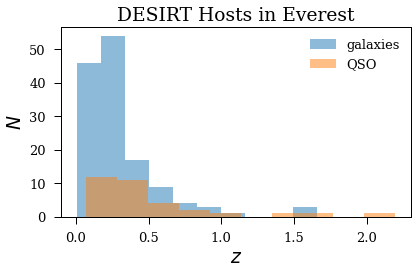

In [41]:
plt_style()
from matplotlib import rc
rc("text", usetex=False)

plt.hist(zhosts[(zhosts>-1) & (ztype=='GALAXY') & (zwarn==0)], label='galaxies',alpha=0.5)
plt.hist(zhosts[(zhosts>-1) & (ztype=='QSO') & (zwarn==0)], label='QSO',alpha=0.5)

plt.legend()
plt.ylabel('$N$')
plt.xlabel('$z$')
plt.title('DESIRT Hosts in Everest')
plt.tight_layout()
plt.savefig('DESIRT_hosts_everest_dndz.png',dpi=200)

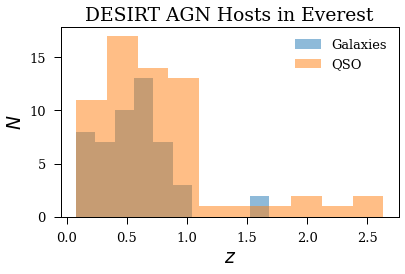

In [40]:


plt.hist(zhosts_agn[(zhosts_agn>-1) & (ztype_agn=='GALAXY') ], label='Galaxies',alpha=0.5)
plt.hist(zhosts_agn[(zhosts_agn>-1) & (ztype_agn=='QSO') ], label='QSO',alpha=0.5)

plt.legend()
plt.ylabel('$N$')
plt.xlabel('$z$')
plt.title('DESIRT AGN Hosts in Everest')
plt.tight_layout()
plt.savefig('DESIRT_hosts_agn_everest_dndz.png',dpi=200)

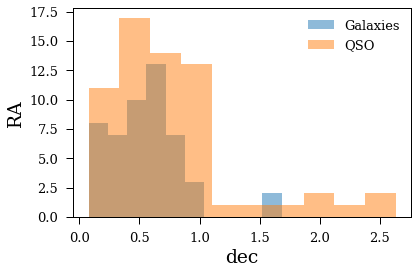

In [39]:
plt.hist(zhosts_agn[(zhosts_agn>-1) & (ztype_agn=='GALAXY') ], label='Galaxies',alpha=0.5)
plt.hist(zhosts_agn[(zhosts_agn>-1) & (ztype_agn=='QSO') ], label='QSO',alpha=0.5)

plt.legend()
plt.ylabel('RA')
plt.xlabel('dec')
plt.tight_layout()
plt.savefig('test.png',dpi=200)

Text(0, 0.5, 'dec')

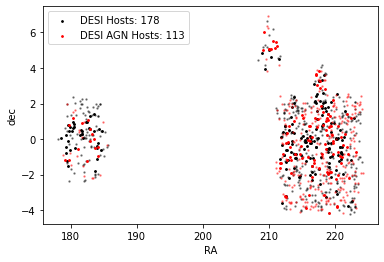

In [41]:
nhosts = decam_transients['RA-PSEUDO-HOST'][zhosts>-1].shape[0] 
nhosts_agn = decam_transients_agn['RA-PSEUDO-HOST'][zhosts_agn>-1].shape[0]

c='k'
plt.scatter(decam_transients['RA-PSEUDO-HOST'],decam_transients['DEC-PSEUDO-HOST'],s=2,c=c,alpha=0.4)
plt.scatter(decam_transients['RA-PSEUDO-HOST'][zhosts>-1],\
            decam_transients['DEC-PSEUDO-HOST'][zhosts>-1],c=c,s=3, label='DESI Hosts: '+str(nhosts))

c='red'
plt.scatter(decam_transients_agn['RA-PSEUDO-HOST'],decam_transients_agn['DEC-PSEUDO-HOST'],c=c,alpha=0.4,s=2)
plt.scatter(decam_transients_agn['RA-PSEUDO-HOST'][zhosts_agn>-1],\
            decam_transients_agn['DEC-PSEUDO-HOST'][zhosts_agn>-1],c=c,s=3, label='DESI AGN Hosts: '+str(nhosts_agn))

plt.legend()
plt.xlabel('RA')
plt.ylabel('dec')

In [35]:
decam_transients['RA-PSEUDO-HOST'][zhosts>-1].shape, decam_transients_agn['RA-PSEUDO-HOST'][zhosts_agn>-1].shape

((178,), (113,))

In [3]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

magpeak=18
magpeak - 5. * np.log10(40.*1e6) + 5., magpeak - 5. * np.log10(40.*1e5)

dist= cosmo.luminosity_distance(0.5663)
21.45 - 5. * np.log10(dist.value*1e6) + 5.

-21.136799956870195

In [17]:
#Plot abs mags for matches
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

peak_absmag =  np.full((decam_transients['RA-PSEUDO-HOST'].shape[0],3), -99.9, dtype=float)
peak_mag = np.full((decam_transients['RA-PSEUDO-HOST'].shape[0],3), -99.9, dtype=float)

objids=decam_transients['ObjectID'][zhosts>-1]
filternames=[b'g',b'r',b'z']

for objid in objids:
    
    idx_obj = decam_transients['ObjectID']==objid
    decam_path = '/global/cfs/cdirs/desi/science/td/DECam/imaging/LCData_Legacy/'+str(objid)+'/lc*csv'
    lc_file = glob.glob(decam_path)

    d= np.genfromtxt(lc_file[0], delimiter=',', names=True, dtype=None)  
    
    ifilter=0
    for filtername in filternames:
        idx= (d['filter']==filtername) & (d['mag']>15)
        try:
            magpeak = d['mag'][idx].min()

            z=zhosts[idx_obj]
            dist= cosmo.luminosity_distance(z)
            absmag = magpeak - 5. * np.log10(dist.value*1e6) + 5.

            peak_absmag[idx_obj,ifilter] = absmag
            peak_mag[idx_obj,ifilter] = magpeak
            ifilter+=1
        except:
            print("Error for ", objid, " in ", filtername ," band")

<ipython-input-17-ec4da481f5ab>:17: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  d= np.genfromtxt(lc_file[0], delimiter=',', names=True, dtype=None)
<ipython-input-17-ec4da481f5ab>:27: RuntimeWarning: invalid value encountered in log10
  absmag = magpeak - 5. * np.log10(dist.value*1e6) + 5.


Error for  A202104151437519p005515  in  b'z'  band
Error for  A202104271157060m002713  in  b'g'  band
Error for  A202104271157570m011240  in  b'g'  band
Error for  A202104271159003p002625  in  b'g'  band
Error for  A202104271200504p002724  in  b'g'  band
Error for  A202104271201259p003735  in  b'g'  band
Error for  A202104271201320p005732  in  b'g'  band
Error for  A202104271201578p004151  in  b'g'  band
Error for  A202104271202016p005013  in  b'g'  band
Error for  A202104271206254p003103  in  b'g'  band
Error for  A202104271207038p001622  in  b'g'  band
Error for  A202104271207362p000507  in  b'g'  band
Error for  A202104271211446p011805  in  b'g'  band
Error for  A202104271213476p012531  in  b'g'  band
Error for  A202105061400244p050138  in  b'g'  band
Error for  A202105061406055p042910  in  b'g'  band
Error for  A202105241154142p000516  in  b'g'  band
Error for  A202105241158256p004820  in  b'g'  band
Error for  A202105241159263p004157  in  b'g'  band
Error for  A202105241205187p001

In [166]:
filtername, ifilter

(b'z', 3)

In [177]:
for all_objid in decam_transients['ObjectID']:
    
    idx_obj = decam_transients['ObjectID']==all_objid
    decam_path = '/global/cfs/cdirs/desi/science/td/DECam/imaging/LCData_Legacy/'+str(all_objid)+'/lc*csv'
    lc_file = glob.glob(decam_path)

    d= np.genfromtxt(lc_file[0], delimiter=',', names=True, dtype=None)  
    
    ifilter=0
    for filtername in filternames:
        idx= (d['filter']==filtername) & (d['mag']>15)
        
        #magpeak = d['mag'][idx].min()
        #peak_mag[idx_obj,ifilter] = magpeak
        
        #ifilter+=1
        try:
            magpeak = d['mag'][idx].min()

            peak_mag[idx_obj,ifilter] = magpeak
            ifilter+=1
        except:
            test=1
            #print("Error for ", objid, " in ", filtername ," band")

<ipython-input-177-4c6a73d5683f>:7: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  d= np.genfromtxt(lc_file[0], delimiter=',', names=True, dtype=None)


No handles with labels found to put in legend.


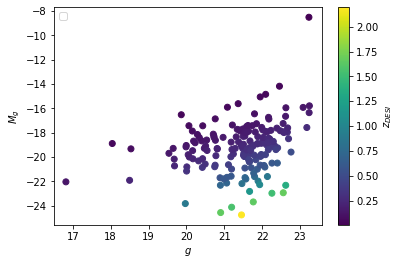

In [18]:
plt.scatter(peak_mag[peak_absmag[:,0]>-90,0],peak_absmag[peak_absmag[:,0]>-90,0],c=zhosts[peak_absmag[:,0]>-90])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$g$')
plt.ylabel('$M_g$')
plt.legend()


No handles with labels found to put in legend.


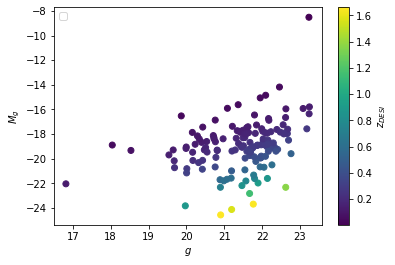

In [20]:
idx_gals = (peak_absmag[:,0]>-90) & (ztype=='GALAXY') 

plt.scatter(peak_mag[idx_gals,0],peak_absmag[idx_gals,0],c=zhosts[idx_gals])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$g$')
plt.ylabel('$M_g$')
plt.legend()


No handles with labels found to put in legend.


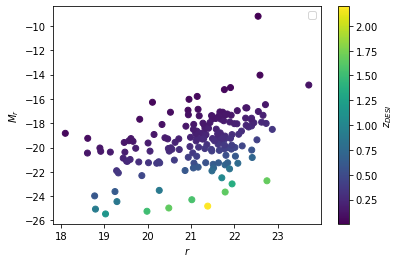

In [189]:

plt.scatter(peak_mag[peak_absmag[:,1]>-30,1],peak_absmag[peak_absmag[:,1]>-30,1],c=zhosts[peak_absmag[:,1]>-30])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$r$')
plt.ylabel('$M_r$')
plt.legend()


No handles with labels found to put in legend.


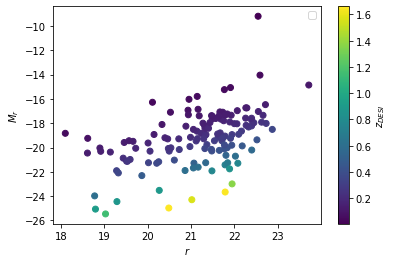

In [21]:
idx_gals = (peak_absmag[:,1]>-90) & (ztype=='GALAXY') 

plt.scatter(peak_mag[idx_gals,1],peak_absmag[idx_gals,1],c=zhosts[idx_gals])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$r$')
plt.ylabel('$M_r$')
plt.legend()

In [26]:
idx_gals = (peak_absmag[:,1]>-90) & (peak_absmag[:,1]<-22) & (ztype=='GALAXY') 
decam_transients['ObjectID'][idx_gals], zhosts[idx_gals]

(31     A202103221432532p005029
 45     A202103221444205m002735
 91     A202104061432308p015321
 130    A202104121440520p000156
 131    A202104121441090p000144
 139    A202104151436246m002825
 182    A202104271213476p012531
 288    A202105301428199p020404
 362    T202104061410268m003625
 395    T202104061437125m010012
 518    T202105271214387m014717
 Name: ObjectID, dtype: object,
 array([0.91448524, 1.65334003, 0.87338165, 0.35942027, 0.48355401,
        1.1553413 , 1.66133865, 0.603275  , 1.36705493, 0.89114651,
        1.57056006]))

No handles with labels found to put in legend.


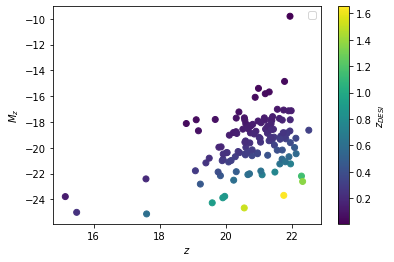

In [190]:
plt.scatter(peak_mag[peak_absmag[:,2]>-30,2],peak_absmag[peak_absmag[:,2]>-30,2],c=zhosts[peak_absmag[:,2]>-30])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$z$')
plt.ylabel('$M_z$')
plt.legend()


No handles with labels found to put in legend.


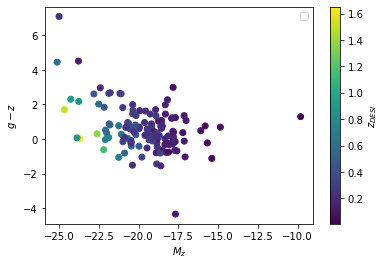

In [191]:
ifilter1=0
ifilter2=2
sel = (peak_absmag[:,ifilter1]>-30) & (peak_absmag[:,ifilter2]>-30)
plt.scatter(peak_absmag[sel,ifilter2],peak_mag[sel,ifilter1]- peak_mag[sel,ifilter2],c=zhosts[sel])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$M_z$')
plt.ylabel('$g-z$')
plt.legend()



In [193]:
40e6/1e6


40.0

No handles with labels found to put in legend.


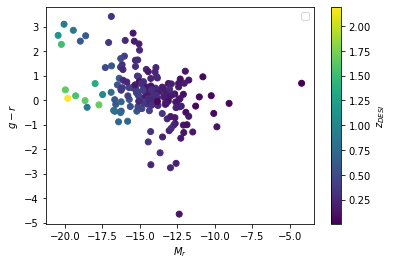

In [157]:
ifilter1=0
ifilter2=1

sel = (peak_absmag[:,ifilter1]>-30) & (peak_absmag[:,ifilter2]>-30)

plt.scatter(peak_absmag[sel,ifilter2],peak_mag[sel,ifilter1]- peak_mag[sel,ifilter2],c=zhosts[sel])
plt.colorbar(label='$z_{DESI}$')
plt.xlabel('$M_r$')
plt.ylabel('$g-r$')
plt.legend()



No handles with labels found to put in legend.


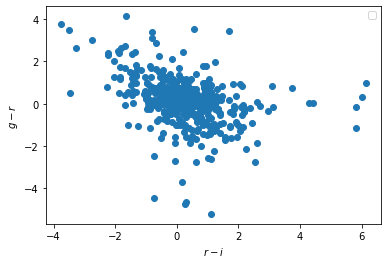

In [178]:
ifilter1=0
ifilter2=1
ifilter3=2

sel = (peak_mag[:,ifilter1]>-30) & (peak_mag[:,ifilter2]>-30) & (peak_mag[:,ifilter3]>-30)

plt.scatter(peak_mag[sel,ifilter2]- peak_mag[sel,ifilter3],peak_mag[sel,ifilter1]- peak_mag[sel,ifilter2]) #,c=zhosts[sel])

plt.xlabel('$r-i$')
plt.ylabel('$g-r$')
plt.legend()



In [1]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    



download_file_from_google_drive('1eELRrSWnNFKPaErHx5k5KVcEaY7WQBz3', \
                                '/global/cfs/cdirs/desi/science/td/DECam/imaging/All_AGN.tar.gz')

### Match to TNS

In [1]:
#!/usr/bin/env python
"""Access TNS using a URL GET. Save the data to CSV.
Adapted from the tns_watcher script by Dima Duev,
https://github.com/dmitryduev/kowalski/blob/master/kowalski/tns_watcher.py
which was ported here by Anna Ho.
Example usage:
> python tns_download.py --classified -n 3
This will download 3 months of alerts classified as SNe and save them to CSV.
"""

import argparse
import requests
import pandas as pd
import io


def download_data(args):
    """Download data from the Transient Name Server.
    Parameters
    ----------
    args : dict
        Dictionary of key-value pairs to pass to the TNS URL GET query.
    Returns
    -------
    tns_data : pandas.DataFrame
        Accumulated data tables from TNS.
    """

    # Build up the URL GET.
    base_url = 'https://www.wis-tns.org/search?format=csv'
    for k, v in args.items():
        if v is None:
            continue
        base_url = f'{base_url}&{k}={v}'

    # User-agent needed for request to go through.
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.55 Safari/537.36'
    }

    # Start the request. Set up a loop through pages returned by TNS.
    # There is a maximum of 500 results per page.
    loop = True
    page = 0
    tns_data = None
    npage = 500
    
    while loop:
        url = f'{base_url}&num_page={npage}&page={page}'
        print(url)
        f = requests.get(url, headers=headers)
        data = pd.read_csv(io.StringIO(f.content.decode('utf-8')), error_bad_lines=False)
    
        # We're done if we have no data...
        if len(data) == 0:
            break
    
        # ...or if the data on this page is less than npage.
        loop = len(data) >= npage
    
        # Accumulate data from each page.
        if tns_data is None:
            tns_data = data
        else:
            tns_data = pd.concat([tns_data, data])
    
        page += 1

    return tns_data



In [ ]:
    p = argparse.ArgumentParser(description='TNS data access script',
            formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    p.add_argument('--classified', dest='classified_sne',
                   default=None, const=1, nargs='?', type=int,
                   help='Require classification of alerts.')
    p.add_argument('-n', '--nperiod', dest='discovered_period_value', default=2,
                   help='Number of periods (days, weeks, months) to check for alerts.')
    p.add_argument('-u', '--units', dest='discovered_period_units', default='months',
                   choices=['days', 'weeks', 'months'],
                   help='Number of periods (days, weeks, months) to check for alerts.')
    p.add_argument('-o', '--output', dest='output', default='tns_search.csv',
                   help='Output CSV file from TNS query.')

    args = p.parse_args()

    # Clean up output arg so it's not passed to download_data.
    output = args.output
    del args.output

    # Access data and save to output.
    tns_data = download_data(vars(args))
    tns_data.to_csv(output)

    print(f'Saved {len(tns_data)} alerts to {output}')

In [ ]:
https://www.wis-tns.org/search?&discovered_period_value=1&discovered_period_units=months&unclassified_at=0&
classified_sne=0&include_frb=0&name=&name_like=0&isTNS_AT=all&public=all&
ra=0.1&decl=0.1&radius=1&coords_unit=arcsec
&reporting_groupid%5B%5D=null&groupid%5B%5D=null&classifier_groupid%5B%5D=null&objtype%5B%5D=null&at_type%5B%5D=null&date_start%5Bdate%5D=&date_end%5Bdate%5D=&discovery_mag_min=&discovery_mag_max=&internal_name=&discoverer=&classifier=&spectra_count=&redshift_min=&redshift_max=&hostname=&ext_catid=&ra_range_min=&ra_range_max=&decl_range_min=&decl_range_max=&discovery_instrument%5B%5D=null&classification_instrument%5B%5D=null&associated_groups%5B%5D=null&official_discovery=0&official_classification=0&at_rep_remarks=&class_rep_remarks=&frb_repeat=all&frb_repeater_of_objid=&frb_measured_redshift=0&frb_dm_range_min=&frb_dm_range_max=&frb_rm_range_min=&frb_rm_range_max=&frb_snr_range_min=&frb_snr_range_max=&frb_flux_range_min=&frb_flux_range_max=&num_page=50&display%5Bredshift%5D=1&display%5Bhostname%5D=1&display%5Bhost_redshift%5D=1&display%5Bsource_group_name%5D=1&display%5Bclassifying_source_group_name%5D=1&display%5Bdiscovering_instrument_name%5D=0&display%5Bclassifing_instrument_name%5D=0&display%5Bprograms_name%5D=0&display%5Binternal_name%5D=1&display%5BisTNS_AT%5D=0&display%5Bpublic%5D=1&display%5Bend_pop_period%5D=0&display%5Bspectra_count%5D=1&display%5Bdiscoverymag%5D=1&display%5Bdiscmagfilter%5D=1&display%5Bdiscoverydate%5D=1&display%5Bdiscoverer%5D=1&display%5Bremarks%5D=0&display%5Bsources%5D=0&display%5Bbibcode%5D=0&display%5Bext_catalogs%5D=0